In [10]:
import pandas as pd

from denovo_utils.analysis.evaluation import (
    calculate_all_accuracy_metrics,
    subset_spectra_on_psmtype,
    evaluate_prediction,
    load_and_preprocess,
    annotate_GMM_clusters,
    filter_gmm_cluster,
    calculate_metrics
)

from denovo_utils.parsers import DenovoEngineConverter

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import json
import os

In [2]:
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

# Filtering all PSMS with gaussian mixture models

Filter the psmslists while keeping some metrics along the way

# 1. Load data

In [3]:
filenames = [
    "F01_Fraction1",
    "F01_Fraction2",
    "F01_Fraction3",
    "F01_Fraction4",
    "F06",
    "F07_Fraction1",
    "F07_Fraction2",
    "F07_Fraction3",
    "F07_Fraction4",
    "F08_Rep1",
    "F08_Rep2",
    "F08_Rep3",
    "S03", # Missing in PT1 (casanovo instanovo ... --> rerun)
    "S05",
    "S07",
    "S08",
    "S11_Fraction1",
    "S11_Fraction2",
    "S11_Fraction3",
    "S11_Fraction4",
    "S14_Rep1",
    "S14_Rep2",
    "S14_Rep3",
]

engines = [
    'Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo',
    'NovoB', 'Novor'
]

In [6]:
root_data="/home/samva/Doctorate/data_directory/denovo_project"
save_directory = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/psmlists_accuracy_filter"

In [18]:
from psm_utils.io import read_file
from glob import glob
root_data = "/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification"

charge_states_list = []
peplength_list = []
for p in glob(root_data+f"/*.sage.tsv"):
    psmlist = read_file(p, filetype="sage")
    charge_states = [i.precursor_charge for i in psmlist["peptidoform"]]
    peplengths = [len(i) for i in psmlist["peptidoform"]]
    charge_states_list.append(charge_states)
    peplength_list.append(peplengths)
    print(p, "completed.")

/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification/S07.sage.tsv completed.
/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification/S11_Fraction3.sage.tsv completed.
/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification/F07_Fraction4.sage.tsv completed.
/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification/F07_Fraction1.sage.tsv completed.
/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification/F01_Fraction4.sage.tsv completed.
/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification/F07_Fraction2.sage.tsv completed.
/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification/S05.sage.tsv completed.
/home/samva/Doctorate/data_directory/denovo_project/search_results/sage/identification/S03.sage.tsv completed.
/home/samva/Doctorate/data_directory/denovo_project/search_res

In [19]:
charge_dict = {}
peplen_dict = {}

for charge_states_file in charge_states_list:
    for charge in charge_states_file:
        if charge not in charge_dict.keys():
            charge_dict[charge] = 1
        else:
            charge_dict[charge] += 1

for peplen_file in peplength_list:
    for peplen in peplen_file:
        if peplen not in peplen_dict.keys():
            peplen_dict[peplen] = 1
        else:
            peplen_dict[peplen] += 1

5      2204
6     16096
7     45638
8     61981
9     72013
10    86256
11    98252
12    96169
13    94714
14    86808
15    85496
16    80024
17    69881
18    63098
19    55721
20    53886
21    43313
22    39360
23    33471
24    28055
25    25511
26    21819
27    19541
28    15994
29    13770
30    11293
31    10901
32     9419
33     7622
34     7075
35     5890
36     5858
37     4843
38     4113
39     3721
40     3907
41     3194
42     2550
43     2146
44     1501
45      961
46      712
47      333
48      195
49       69
50       32
dtype: int64


<Axes: >

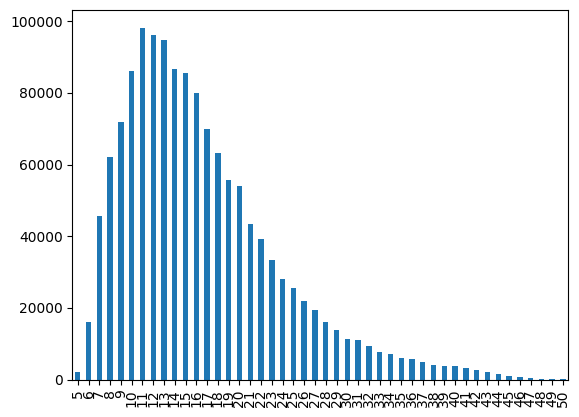

In [20]:
print(pd.Series(peplen_dict).sort_index())
pd.Series(peplen_dict).sort_index().plot(kind="bar")

1     12289
2    787012
3    515747
4     69300
5      9149
6      1842
7        40
8        27
dtype: int64


<Axes: >

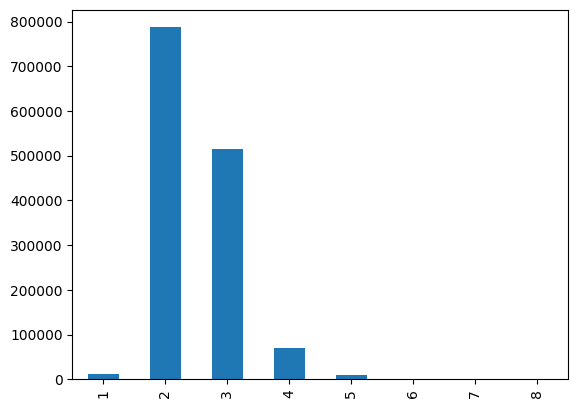

In [21]:
print(pd.Series(charge_dict).sort_index())
pd.Series(charge_dict).sort_index().plot(kind="bar")

# For a single file

In [5]:
# Load all data in a dataframe and do some basic preprocessing
df = load_and_preprocess(
    root=root_data,
    filename="F01_Fraction1"
)

['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']


In [6]:
# Fit GMMs and assign cluster labels to PSMs
df, gmm_metrics = annotate_GMM_clusters(df, db_engine="sage", only_df=False)

In [7]:
df_filtered = filter_gmm_cluster(df=df, keep_cluster_label=1)

metrics = calculate_metrics(
    df_filtered,
    engines=engines
)

In [8]:
df_filtered.to_csv("/home/samva/Doctorate/data_directory/denovo_project/denovo_results/psmlists/df/F01_Fraction1.csv", index=False)

# For all files

In [7]:
metrics = {}
metrics_gmm = {}
df_filtered = {}

In [8]:
import json
def save_to_json(data, path):
    with open(path, "w") as f:
        json_obj = json.dumps(data, indent=4)
        f.write(json_obj)

In [6]:
for filename in filenames:
    print(filename)

    # Load data, parse and preprocess a bit
    df = load_and_preprocess(
        root=root_data,
        filename=filename
    )
    
    # Fit GMMs and assign cluster labels to PSMs
    df, metrics_gmm_file = annotate_GMM_clusters(df, db_engine="sage", only_df=False)
    df_filtered_file = filter_gmm_cluster(df=df, keep_cluster_label=1)

    # Get some accuracy metrics for evaluation of the filtering
    metrics_file = calculate_metrics(
        df_filtered_file,
        engines=engines
    )

    # Store
    df_filtered_file.to_csv(os.path.join(
        save_directory, "df", filename+".csv"
    ), index=False)

    save_to_json(metrics_file, 
                 os.path.join(
                     save_directory,
                     "metrics",
                     filename+"_accuracy.json"
                 ))
    save_to_json(metrics_gmm_file, 
                 os.path.join(
                     save_directory,
                     "metrics",
                     filename+"_gmm.json"
                 ))

F01_Fraction1
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F01_Fraction2
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F01_Fraction3
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F01_Fraction4
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F06
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F07_Fraction1
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F07_Fraction2
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F07_Fraction3
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F07_Fraction4
['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'ContraNovo']
['NovoB', 'Novor', 'PepNovo+']
['sage']
F08_Rep1
['Casanovo4.2.0', 'I

---

Filtering on a de novo score threshold

In [23]:
set_threshold = {
    'casanovo': 0.9423831251120693,
    'contranovo': 0.9777301218350248,
    'instanovo': -0.972949795817074,
    'pepnet': 0.9802,
    'novob': 0.8842544444444446,
    'novor': 96.67333333333332
}

engines = [
    'casanovo',
    'instanovo',
    'pepnet',
    'contranovo',
    'novob',
    'novor'
]

save_directory = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/psmlists_accuracy_filter"

In [15]:
from denovo_utils.utils.pandas import collapse_casanovo_score

In [26]:
for filename in filenames:
    print(filename)
    df_list = []
    for engine in engines:
        # Original result output
        result_path = os.path.join(
            root_data, "denovo_results", engine, filename
        )
        # Path to MGF raw data
        mgf_path = os.path.join(
            root_data, "mgf_filtered", filename+".mgf"
        )
        # Selected threshold (unified over this project based on means)
        threshold = set_threshold[engine]

        # Parse the de novo results
        parser = DenovoEngineConverter.select(engine)
        psmlist = parser.parse(result_path, mgf_path=mgf_path)
        psm_df = psmlist.to_dataframe()
        
        # Filter on a 95% lenient accuracy
        psm_df = psm_df[(psm_df.score >= threshold)]
        psm_df["score"] = psm_df.apply(collapse_casanovo_score, axis=1)
        psm_df["sequence"] = psm_df.peptidoform.apply(lambda x: x.sequence)
        psm_df["proforma"] = psm_df.peptidoform.apply(lambda x: x.proforma)
        psm_df["filename"] = filename
        psm_df = psm_df.loc[
            :,
            ["proforma", "sequence", "score", "source", "spectrum_id", "filename"]
        ]
        df_list.append(psm_df)

    df_files = pd.concat(df_list)
    print(df_files.value_counts("source"))
    df_files.to_csv(
        os.path.join(
            save_directory,
            filename+".csv"
        ),
        index=False
    )

F01_Fraction1
source
Casanovo4.2.0    1275
ContraNovo        900
InstaNovo         803
NovoB             501
PepNet            359
Novor               2
Name: count, dtype: int64
F01_Fraction2
source
Casanovo4.2.0    35374
InstaNovo        21425
ContraNovo       18657
NovoB            17540
PepNet           15960
Novor              227
Name: count, dtype: int64
F01_Fraction3
source
Casanovo4.2.0    27351
InstaNovo        18720
NovoB            15034
ContraNovo       14733
PepNet           11727
Novor              211
Name: count, dtype: int64
F01_Fraction4
source
Casanovo4.2.0    17630
InstaNovo        12923
ContraNovo        9771
NovoB             8364
PepNet            6554
Novor               41
Name: count, dtype: int64
F06
source
Casanovo4.2.0    36295
InstaNovo        32060
NovoB            24986
ContraNovo       19124
PepNet           17035
Novor              428
Name: count, dtype: int64
F07_Fraction1
source
Casanovo4.2.0    15889
InstaNovo        14389
NovoB            11430
C

In [32]:
from denovo_utils.utils.pandas import amino_acid_converter
from psm_utils import Peptidoform
from glob import glob

In [50]:
"KDQADNEPSGN[UNIMOD:7]GHPASAK/3".replace("N[UNIMOD:7]", "D")

'KDQADNEPSGDGHPASAK/3'

In [67]:
root_sage = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/sage"

for p in glob("/home/samva/Doctorate/data_directory/denovo_project/denovo_results/psmlists_accuracy_filter/*"):
    df = pd.read_csv(p).loc[
        :,
        ["proforma", "sequence", "score", "source", "spectrum_id", "filename"]
    ]
    mapping = {
        "N[UNIMOD:7]": "D",
        "Q[UNIMOD:7]": "E",
        "I": "L",
        "UNLMOD": "UNIMOD",  # Otherwise the I in UNIMOD is replaced with L
        
    }
    df["sequence"] = df.proforma.apply(
        lambda x: amino_acid_converter(
            row={"peptidoform": Peptidoform(x)},
            mapping=mapping
        ).sequence
    )
    os.path.basename(p).split(".")[0]
    parser = DenovoEngineConverter.select("sage")
    df_sage = parser.parse(
        os.path.join(root_sage, os.path.basename(p).split(".")[0]+".sage.tsv"),
        mgf_path=""
    ).to_dataframe()
    df_sage = df_sage[
        (~df_sage.is_decoy) &
        (df_sage.qvalue < .01)
    ]
    df_sage["proforma"] = df_sage.peptidoform.apply(lambda x: x.proforma)
    df_sage["sequence"] = df_sage.peptidoform.apply(lambda x: x.sequence)
    df_sage["filename"] = os.path.basename(p).split(".")[0]
    df_sage = df_sage.loc[
        :,
        ["proforma", "sequence", "score", "source", "spectrum_id", "filename"]
    ]
    
    df = pd.concat([df, df_sage], axis=0)
    df.to_csv(p, index=False)
    